In [1]:
!pip install qiskit-terra==0.24.1 qiskit-aer==0.12.0 qiskit-ibmq-provider==0.20.2 qiskit==0.43.1 qiskit-machine-learning==0.6.1

This is implemented on 15/07/2025 by shanika

Dataset: WDBC
Source : Dua, D. and Graff, C. (2019). UCI Machine Learning Repository http://archive.ics.uci.edu/ml. Irvine, CA: University of California, School of Information and Computer Science. Breast Cancer Wisconsin (Diagnostic) Data Set.

In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Qiskit core components
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_aer import Aer
from qiskit.primitives import BackendSampler

# Qiskit Machine Learning components
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import VQC, NeuralNetworkClassifier

# Qiskit algorithms and utilities
from qiskit.algorithms.optimizers import COBYLA, SPSA
from qiskit.utils import algorithm_globals

# Set random seed for reproducibility
algorithm_globals.random_seed = 42

# Scikit-learn utilities
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [12]:
# Callback function to capture the loss values
objective_func_vals = []  # Global list to store loss values
learning_rates = []
perturbations = []

#-------Split data for federated Setting--------#
num_epochs = 10
max_train_iterations = 50
samples_per_epoch=50
#backend = Aer.get_backend('aer_simulator')


# Configuration variables
num_clients = 5
num_federated_layers = 10
num_deep_unfolding_iterations = 5
initial_learning_rate = 0.15

initial_perturbation = 0.15
momentum = 0.95
gradient_moving_avg = 0

# Define federated learning with accuracy tracking
#num_features = 5
global_model_weights, global_model_accuracy = {}, []
clients_train_accuracies, clients_test_accuracies = [], []

In [4]:
import os  # For handling directories

# Define the directory to save the plots
output_dir = "federated_round_plots"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
# Initialize a global variable to track the round number
current_round = 1
# Callback for visualization, gradient smoothing, and learning rate adjustment in deep unfolding
def deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients=None,round_number=0):
    global gradient_moving_avg, learning_rates, perturbations,current_round

    clear_output(wait=True)

    # Save the objective function value for visualization
    objective_func_vals.append(obj_func_eval)

    # If gradients are provided, smooth the gradient using momentum
    if gradients is not None:
        gradient_moving_avg = momentum * gradient_moving_avg + (1 - momentum) * gradients  # Apply moving average
        # Calculate delta_lr and delta_perturbation as scalar values
        delta_lr = 0.05 * np.mean(gradient_moving_avg)  # Adjust learning rate based on the mean of smoothed gradient
        delta_perturbation = 0.1 * np.mean(gradient_moving_avg)  # Adjust perturbation based on the mean of the same gradient
    else:
        delta_lr = 0  # No gradient info available in this iteration
        delta_perturbation = 0

    # Update learning rate and perturbation
    if len(learning_rates) > 0:
        new_lr = max(0.001, learning_rates[-1] + delta_lr)  # Ensure learning rate is positive and non-zero
        new_perturbation = max(0.001, perturbations[-1] + delta_perturbation)  # Ensure perturbation is positive
    else:
        new_lr = initial_learning_rate
        new_perturbation = initial_perturbation

    learning_rates.append(new_lr)
    perturbations.append(new_perturbation)

    import matplotlib.pyplot as plt

    # Visualization of learning rate and perturbation
    plt.figure(figsize=(10, 12))  # Adjust figure size for better spacing

    # Plot Objective Function Value
    plt.subplot(3, 1, 1)
    plt.plot(range(len(objective_func_vals)), objective_func_vals, label="Objective Function Value", color='blue')
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.title("Objective Function Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)  # Add grid for better readability

    # Plot Learning Rate
    plt.subplot(3, 1, 2)
    plt.plot(range(len(learning_rates)), learning_rates, label="Learning Rate", color='green')
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)

    # Plot Perturbation
    plt.subplot(3, 1, 3)
    plt.plot(range(len(perturbations)), perturbations, label="Perturbation", color='red')
    plt.xlabel("Iteration")
    plt.ylabel("Perturbation")
    plt.title("Perturbation Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)

    plt.tight_layout(pad=3.0)  # Add padding between subplots
    # Save the plot after each federated round
    #plot_filename = os.path.join(output_dir, f"federated_round_{current_round}.png")
    #plt.savefig(plot_filename)  # Save the figure
    #plt.show()
    plt.close()  # Close the plot to free memory

    # Increment the round number for the next call
    current_round += 1

In [9]:


# Define the SPSA callback to capture gradients and update learning rate and perturbation dynamically
def spsa_callback(nfev, parameters, obj_func_eval, stepsize, accept):
    # Assuming `stepsize` contains gradient information or its approximation
    gradients = stepsize
    deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients)


In [13]:
# Custom SPSA optimizer with learnable learning rate and perturbation
class LearnableLRPerturbationSPSA(SPSA):
    def __init__(self, initial_lr=0.15, initial_perturbation=0.15, lr_alpha=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = initial_lr  # Initial learning rate
        self.perturbation = initial_perturbation  # Initial perturbation
        self.lr_alpha = lr_alpha  # Learning rate and perturbation update speed

    def _update_learning_rate_and_perturbation(self, gradient, obj_func_eval):
        """
        Update both learning rate and perturbation based on gradient and objective function evaluation.
        The learning rate increases if the objective function improves and decreases otherwise.
        """
        # Use the gradient sign to determine if we should increase or decrease
        grad_lr = np.sign(np.mean(gradient))  # Average gradient sign across parameters

        if grad_lr > 0:  # Objective function is improving
            self.lr += self.lr_alpha * abs(grad_lr)  # Increase learning rate
            self.perturbation += self.lr_alpha * abs(grad_lr)  # Increase perturbation
        else:  # Objective function is getting worse
            self.lr -= self.lr_alpha * abs(grad_lr)  # Decrease learning rate
            self.perturbation -= self.lr_alpha * abs(grad_lr)  # Decrease perturbation

        # Ensure both learning rate and perturbation are positive
        self.lr = max(0.001, self.lr)
        self.perturbation = max(0.001, self.perturbation)

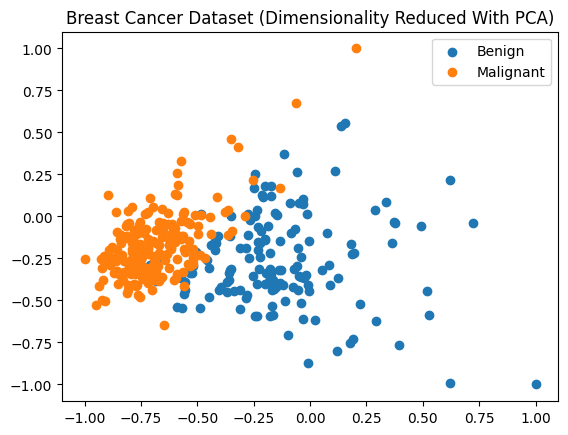

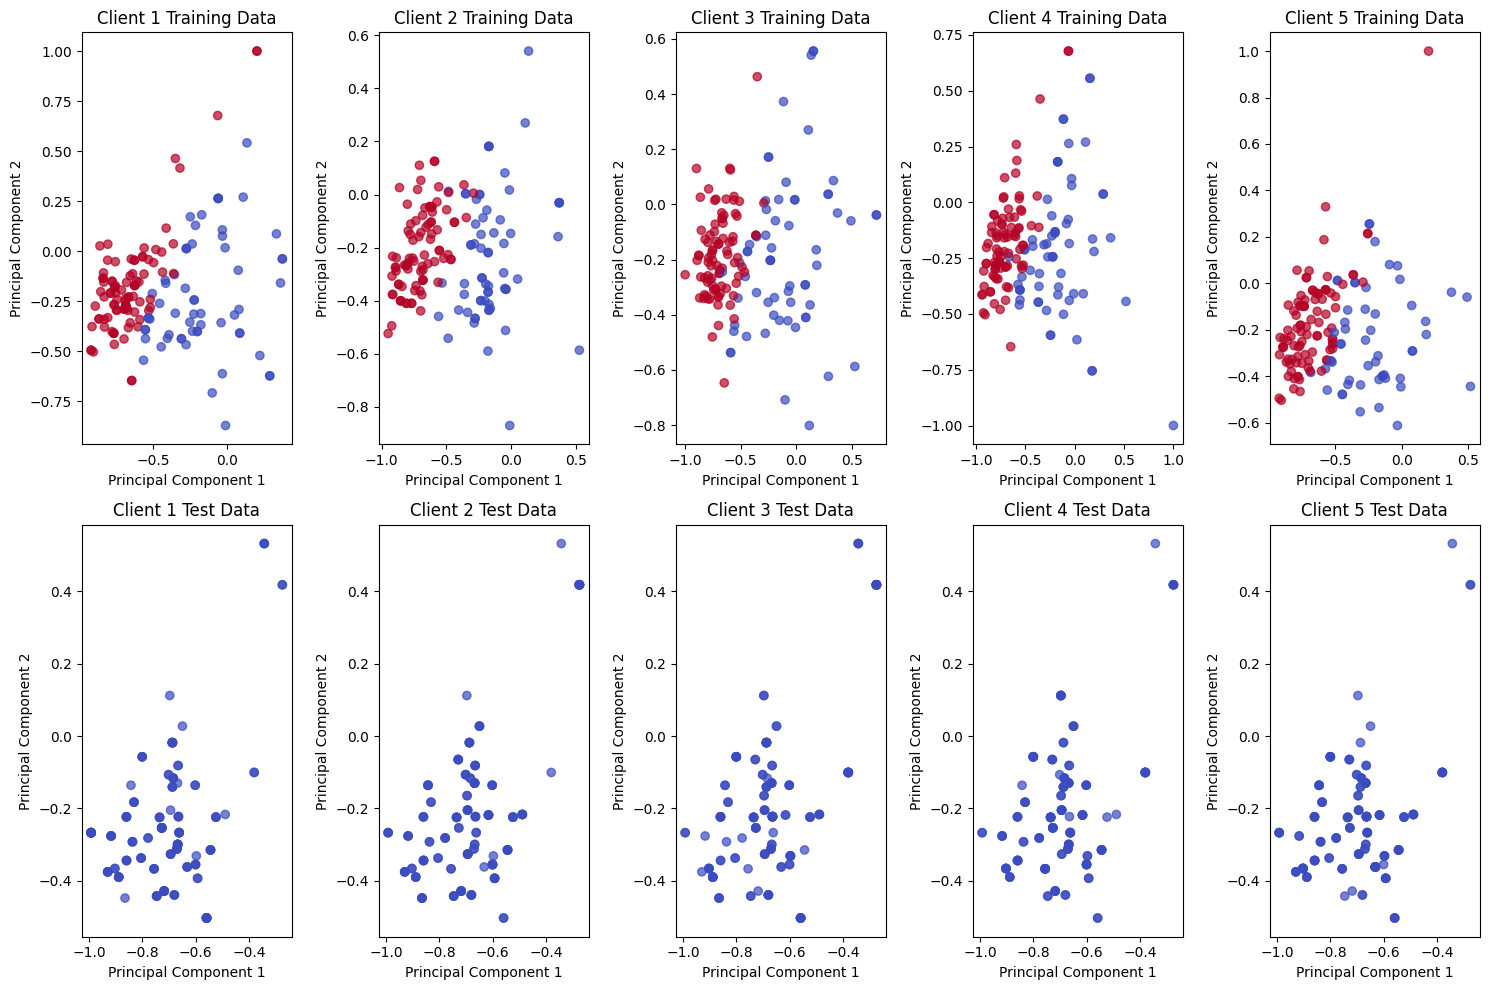

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Function to preprocess breast cancer dataset
def breast_cancer(training_size, test_size, n, PLOT_DATA=True):
    class_labels = [r'Benign', r'Malignant']

    # Load the dataset
    cancer = datasets.load_breast_cancer()

    # Split into training and testing datasets
    X_train, X_test, Y_train, Y_test = train_test_split(cancer.data, cancer.target, test_size=0.3, random_state=109)

    # Standardize features to fit a normal distribution
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Reduce dimensions to `n` principal components
    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # Scale data between -1 and 1
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    # Prepare training and testing data
    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_train[Y_train == k, :])[training_size:(training_size + test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]
            label = 'Malignant' if k == 1 else 'Benign'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("Breast Cancer Dataset (Dimensionality Reduced With PCA)")
        plt.legend()
        plt.show()

    return X_train, training_input, test_input, class_labels

# Function to split dataset into data and labels
def split_dataset_to_data_and_labels(input_data):
    data = []
    labels = []
    for label, features in input_data.items():
        data.append(features)
        if label == 'Benign':
            labels.append([0] * len(features))
        else:
            labels.append([1] * len(features))
    return np.vstack(data), np.hstack(labels)

# Function to assign overlapping random portions of data to clients
def assign_random_data_to_clients(data, labels, num_clients, data_per_client):
    """
    Assign overlapping random portions of the dataset to each client.

    Parameters:
    - data: NumPy array of data points.
    - labels: NumPy array of corresponding labels.
    - num_clients: Number of clients.
    - data_per_client: Number of samples per client.

    Returns:
    - client_data: List of data arrays for each client.
    - client_labels: List of label arrays for each client.
    """
    client_data = []
    client_labels = []
    for _ in range(num_clients):
        indices = np.random.choice(len(data), data_per_client, replace=True)  # Allow overlap
        client_data.append(data[indices])
        client_labels.append(labels[indices])
    return client_data, client_labels

# Set parameters
n = 2  # Number of principal components
training_dataset_size = 200
testing_dataset_size = 100
num_clients = 5
data_per_client = 150  # Number of samples each client should have

# Preprocess the dataset
sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

# Split training and test datasets into data and labels
data_train, train_labels = split_dataset_to_data_and_labels(training_input)
data_test, test_labels = split_dataset_to_data_and_labels(test_input)

train_samples_list = [40, 60, 80, 100, 120]
test_samples_list = [20, 30, 30, 20, 25]

# Assign random data portions to clients for both training and test data
client_data, client_labels = assign_random_data_to_clients(data_train, train_labels, num_clients, data_per_client)
client_test_data, client_test_labels = assign_random_data_to_clients(data_test, test_labels, num_clients, data_per_client)

# Visualize training and test data for each client
fig, axes = plt.subplots(2, num_clients, figsize=(15, 10))

for i in range(num_clients):
    # Plot training data
    axes[0, i].scatter(client_data[i][:, 0], client_data[i][:, 1], c=client_labels[i], cmap="coolwarm", alpha=0.7)
    axes[0, i].set_title(f"Client {i+1} Training Data")
    axes[0, i].set_xlabel("Principal Component 1")
    axes[0, i].set_ylabel("Principal Component 2")

    # Plot test data
    axes[1, i].scatter(client_test_data[i][:, 0], client_test_data[i][:, 1], c=client_test_labels[i], cmap="coolwarm", alpha=0.7)
    axes[1, i].set_title(f"Client {i+1} Test Data")
    axes[1, i].set_xlabel("Principal Component 1")
    axes[1, i].set_ylabel("Principal Component 2")

plt.tight_layout()
plt.show()


In [15]:
# Convert client data and labels into dictionaries
clients = []
for i in range(num_clients):
    clients.append({
        "train_data": {"data": client_data[i], "labels": client_labels[i]},
        "test_data": {"data": client_test_data[i], "labels": client_test_labels[i]}
    })

# Display information about the data assigned to each client, including epoch-wise splits
for idx, client in enumerate(clients):
    print(f"Client {idx + 1}:")
    for epoch in range(num_epochs):
        print(f"  Epoch {epoch + 1}: Train data samples: {len(client['train_data']['data'])}")  # Access train data from dictionary
    print(f"  Test data samples: {len(client['test_data']['data'])}")  # Access test data from dictionary

Client 1:
  Epoch 1: Train data samples: 150
  Epoch 2: Train data samples: 150
  Epoch 3: Train data samples: 150
  Epoch 4: Train data samples: 150
  Epoch 5: Train data samples: 150
  Epoch 6: Train data samples: 150
  Epoch 7: Train data samples: 150
  Epoch 8: Train data samples: 150
  Epoch 9: Train data samples: 150
  Epoch 10: Train data samples: 150
  Test data samples: 150
Client 2:
  Epoch 1: Train data samples: 150
  Epoch 2: Train data samples: 150
  Epoch 3: Train data samples: 150
  Epoch 4: Train data samples: 150
  Epoch 5: Train data samples: 150
  Epoch 6: Train data samples: 150
  Epoch 7: Train data samples: 150
  Epoch 8: Train data samples: 150
  Epoch 9: Train data samples: 150
  Epoch 10: Train data samples: 150
  Test data samples: 150
Client 3:
  Epoch 1: Train data samples: 150
  Epoch 2: Train data samples: 150
  Epoch 3: Train data samples: 150
  Epoch 4: Train data samples: 150
  Epoch 5: Train data samples: 150
  Epoch 6: Train data samples: 150
  Epoch 

In [16]:

import os  # For handling directories

# Define the directory to save the plots
output_dir = "federated_round_plots"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
# Initialize a global variable to track the round number
current_round = 1
# Callback for visualization, gradient smoothing, and learning rate adjustment in deep unfolding
def deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients=None,round_number=0):
    global gradient_moving_avg, learning_rates, perturbations,current_round

    clear_output(wait=True)

    # Save the objective function value for visualization
    objective_func_vals.append(obj_func_eval)

    # If gradients are provided, smooth the gradient using momentum
    if gradients is not None:
        gradient_moving_avg = momentum * gradient_moving_avg + (1 - momentum) * gradients  # Apply moving average
        delta_lr = 0.05 * gradient_moving_avg  # Adjust learning rate based on the smoothed gradient
        delta_perturbation = 0.1 * gradient_moving_avg  # Adjust perturbation based on the same gradient
    else:
        delta_lr = 0  # No gradient info available in this iteration
        delta_perturbation = 0

    # Update learning rate and perturbation
    if len(learning_rates) > 0:
        new_lr = max(0.001, learning_rates[-1] + delta_lr)  # Ensure learning rate is positive and non-zero
        new_perturbation = max(0.001, perturbations[-1] + delta_perturbation)  # Ensure perturbation is positive
    else:
        new_lr = initial_learning_rate
        new_perturbation = initial_perturbation

    learning_rates.append(new_lr)
    perturbations.append(new_perturbation)

    import matplotlib.pyplot as plt

    # Visualization of learning rate and perturbation
    plt.figure(figsize=(10, 12))  # Adjust figure size for better spacing

    # Plot Objective Function Value
    plt.subplot(3, 1, 1)
    plt.plot(range(len(objective_func_vals)), objective_func_vals, label="Objective Function Value", color='blue')
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.title("Objective Function Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)  # Add grid for better readability

    # Plot Learning Rate
    plt.subplot(3, 1, 2)
    plt.plot(range(len(learning_rates)), learning_rates, label="Learning Rate", color='green')
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)

    # Plot Perturbation
    plt.subplot(3, 1, 3)
    plt.plot(range(len(perturbations)), perturbations, label="Perturbation", color='red')
    plt.xlabel("Iteration")
    plt.ylabel("Perturbation")
    plt.title("Perturbation Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)

    plt.tight_layout(pad=3.0)  # Add padding between subplots
    # Save the plot after each federated round
    #plot_filename = os.path.join(output_dir, f"federated_round_{current_round}.png")
    #plt.savefig(plot_filename)  # Save the figure
    #plt.show()
    plt.close()  # Close the plot to free memory

    # Increment the round number for the next call
    current_round += 1



In [17]:


# Define the SPSA callback to capture gradients and update learning rate and perturbation dynamically
def spsa_callback(nfev, parameters, obj_func_eval, stepsize, accept):
    # Assuming `stepsize` contains gradient information or its approximation
    gradients = stepsize
    deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients)


In [18]:
# Custom SPSA optimizer with learnable learning rate and perturbation
class LearnableLRPerturbationSPSA(SPSA):
    def __init__(self, initial_lr=0.15, initial_perturbation=0.15, lr_alpha=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = initial_lr  # Initial learning rate
        self.perturbation = initial_perturbation  # Initial perturbation
        self.lr_alpha = lr_alpha  # Learning rate and perturbation update speed

    def _update_learning_rate_and_perturbation(self, gradient, obj_func_eval):
        """
        Update both learning rate and perturbation based on gradient and objective function evaluation.
        The learning rate increases if the objective function improves and decreases otherwise.
        """
        # Use the gradient sign to determine if we should increase or decrease
        grad_lr = np.sign(np.mean(gradient))  # Average gradient sign across parameters

        if grad_lr > 0:  # Objective function is improving
            self.lr += self.lr_alpha * abs(grad_lr)  # Increase learning rate
            self.perturbation += self.lr_alpha * abs(grad_lr)  # Increase perturbation
        else:  # Objective function is getting worse
            self.lr -= self.lr_alpha * abs(grad_lr)  # Decrease learning rate
            self.perturbation -= self.lr_alpha * abs(grad_lr)  # Decrease perturbation

        # Ensure both learning rate and perturbation are positive
        self.lr = max(0.001, self.lr)
        self.perturbation = max(0.001, self.perturbation)

In [19]:
    def step(self, gradient, obj_func_eval):
        """
        Perform optimization step for both parameters, learning rate, and perturbation.
        Use the objective function evaluation to dynamically adjust learning rate and perturbation.
        """
        self._update_learning_rate_and_perturbation(gradient, obj_func_eval)
        return super().step(gradient)  # Perform SPSA step for parameters

    def reset(self):
        """
        Reset the optimizer state (learning rates, perturbations, and gradient moving averages) for the next round.
        """
        self.lr = initial_learning_rate
        self.perturbation = initial_perturbation
        self.gradient_moving_avg = 0  # Reset the moving average of the gradient
        learning_rates.clear()  # Reset the learning rates history
        perturbations.clear()  # Reset the perturbations history
        objective_func_vals.clear()  # Clear the objective function history

In [20]:
# Create optimizer with learnable learning rate and perturbation
spsa_optimizer = LearnableLRPerturbationSPSA(
      maxiter=50, learning_rate=initial_learning_rate, perturbation=initial_perturbation, callback=spsa_callback, lr_alpha=0.01
)

Initialize QNN model for each client at the start of the Federated Round

In [21]:
#======================================================
# Initialize QNN model
def initialize_model(num_features,initial_params):
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    qc = feature_map.compose(ansatz)


    # Create optimizer with learnable learning rate and perturbation
    spsa_optimizer = LearnableLRPerturbationSPSA(
      maxiter=50, learning_rate=initial_learning_rate, perturbation=initial_perturbation, callback=spsa_callback, lr_alpha=0.01
)
    def parity(x):
        return "{:b}".format(x).count("1") % 2

    sampler_qnn = SamplerQNN(
        circuit=qc,
        interpret=parity,
        output_shape=2,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )


    # Define the neural network classifier
    qnn_classifier = NeuralNetworkClassifier(
      neural_network=sampler_qnn,
      optimizer=spsa_optimizer,
      loss='squared_error',
      initial_point=initial_params,  # Initialize with the starting parameters
)


    return qnn_classifier

In [23]:
#=====================================================
from google.colab import drive
import csv
# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the save path in Google Drive
csv_file = '/content/drive/My Drive/DUQFL_local_WDBC_ML_KEM.csv'

# Step 3: Define headers for the CSV
headers = ["Federated Round", "Client Number", "Iteration", "Objective Function Value",
           "Training Accuracy", "Test Accuracy", "Learning Rate", "Perturbation","raw_entropy", "encrypted_entropy","Unauthorized Decryption", "Fake Accuracy", "Encryption Status"]

# Open the CSV file and write headers if it's the first time writing to the file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)

# Example of saving results for each federated round and client
def save_results(federated_round, client_id, iteration, obj_func_val, train_acc, test_acc, learning_rate, perturbation,raw_entropy, encrypted_entropy, unauthorized_status, fake_acc, encryption_status):
    with open(csv_file, mode='a', newline='') as file:  # Open file in append mode
        writer = csv.writer(file)
        writer.writerow([federated_round, client_id, iteration, obj_func_val, train_acc, test_acc, learning_rate, perturbation,raw_entropy, encrypted_entropy,unauthorized_status, fake_acc, encryption_status])
##=====================================================



Mounted at /content/drive


# === Secure DUQFL Integration with ML-KEM ===

In [24]:
!pip install kyber_py pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.9 MB/s eta 0:00:00


In [25]:
from kyber_py.ml_kem import ML_KEM_512
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import numpy as np

In [26]:
# === SERVER SIDE SETUP ===
# Generate server key pair (once)
ek_server, dk_server = ML_KEM_512.keygen()

In [27]:
from Crypto.Random import get_random_bytes


In [28]:
def simulate_unauthorized_decryption(ciphertext, capsule):
    try:
        # Attempt to decapsulate with incorrect key
        K_fake = ML_KEM_512.decaps(dk_fake_adversary, capsule)
        cipher = AES.new(K_fake[:16], AES.MODE_ECB)
        decrypted = unpad(cipher.decrypt(ciphertext), 16)
        print("[Attack Simulation] Decryption succeeded (Unexpected).")
        return decrypted
    except Exception as e:
        print("[Attack Simulation] Decryption failed (As Expected):", str(e))
        return None


In [29]:
#=====================================================
# === CLIENT SIDE: INSIDE train_qnn_model() ===
# Federated learning loop per client

encrypted_model_storage = {}
dk_fake_adversary = get_random_bytes(1632)

#Measure entropy of transmitted parameters
from scipy.stats import entropy
from collections import Counter

def compute_byte_entropy(byte_array):
    counter = Counter(byte_array)
    probabilities = [count / len(byte_array) for count in counter.values()]
    return entropy(probabilities, base=2)


def train_qnn_model(client_data, client_test_data, model=None, client_id=None, layer=None, enable_encryption=True):
    global encrypted_model_storage  # Fixes the scope
    num_features = client_data["data"].shape[1]
    print(f"Client {client_id} - Number of features: {num_features}")

    initial_params = np.random.rand(RealAmplitudes(num_features, reps=3).num_parameters)

    if model is None:
        model = initialize_model(num_features, initial_params)

    train_sequences = client_data["data"]
    train_labels = client_data["labels"]
    test_sequences = client_test_data["data"]
    test_labels = client_test_data["labels"]

    train_accuracies, test_accuracies, total_time = [], [], 0
    current_params = initial_params

    for i in range(num_deep_unfolding_iterations):
        print(f"\nDeep Unfolding Iteration {i+1}/{num_deep_unfolding_iterations}")
        start_time = time.time()
        model.fit(train_sequences, train_labels)
        end_time = time.time()
        total_time += end_time - start_time

        current_params = model.weights
        final_learning_rate = learning_rates[-1]
        final_perturbation = perturbations[-1]

        train_accuracy = model.score(train_sequences, train_labels)
        test_accuracy = model.score(test_sequences, test_labels)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        model_bytes = np.array(current_params).tobytes()

        if enable_encryption:
            try:
                K, c = ML_KEM_512.encaps(ek_server)
                cipher = AES.new(K[:16], AES.MODE_ECB)
                ciphertext = cipher.encrypt(pad(model_bytes, 16))
                encryption_status = "HPKE Secure"
            except Exception as e:
                print("[Encryption Failed]:", str(e))
                ciphertext, c, encryption_status = b'', None, "Encryption Error"
        else:
            ciphertext = model_bytes
            c = None
            encryption_status = "No Encryption"

        encrypted_model_storage[client_id] = (ciphertext, c)
        tampered_bytes = simulate_unauthorized_decryption(ciphertext, c) if enable_encryption else ciphertext

        if tampered_bytes:
            try:
                tampered_weights = np.frombuffer(tampered_bytes, dtype=np.float64)
                fake_model = initialize_model(num_features, tampered_weights)
                fake_accuracy = fake_model.score(test_sequences, test_labels)
                unauthorized_status = "Success"
            except Exception as e:
                fake_accuracy = 0.0
                print("[Fake Model Reconstruction Failed]:", str(e))
                unauthorized_status = "Success (Corrupted)"
        else:
            fake_accuracy, unauthorized_status = 0.0, "Fail"

        raw_entropy = compute_byte_entropy(model_bytes)
        encrypted_entropy = compute_byte_entropy(ciphertext)

        print(f"[Security] Raw Entropy: {raw_entropy:.2f}, Encrypted Entropy: {encrypted_entropy:.2f}")
        print(f"[Security] Unauthorized Access: {unauthorized_status}, Fake Accuracy: {fake_accuracy:.2f}")
        print(f"[Security] Mode: {encryption_status}")

        save_results(
            layer, client_id, i + 1,
            objective_func_vals[-1],
            train_accuracy * 100,
            test_accuracy * 100,
            final_learning_rate,
            final_perturbation,
            raw_entropy,
            encrypted_entropy,
            unauthorized_status,
            fake_accuracy * 100,
            encryption_status  # <-- NEW
        )

        spsa_optimizer.learning_rate = learning_rates[-1]
        model.initial_point = current_params

        print(f"Iteration {i+1} - Learning Rate: {final_learning_rate:.6f}")
        print(f"Iteration {i+1} - Training Accuracy: {train_accuracy * 100:.2f}%")
        print(f"Iteration {i+1} - Test Accuracy: {test_accuracy * 100:.2f}%")

    return model, train_accuracy, test_accuracy, total_time


In [30]:
# Step to empty the CSV file before starting a new run
def clear_csv_file():
    """
    Clears the CSV file by overwriting it with headers or leaving it blank.
    """
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Uncomment the next line to write headers for the new run
        writer.writerow(headers)
        # Leave it blank if you prefer not to include headers
        # pass


In [31]:
def get_accuracy(model, test_sequences, test_labels):
    """
    Evaluate the accuracy of the given model on the test dataset.

    Parameters:
        model: The trained model to evaluate.
        num_features: The number of features in each data sample.
        test_sequences: A list or array of test input data (features).
        test_labels: A list or array of true labels corresponding to the test data.

    Returns:
        float: The accuracy of the model as a percentage.
    """
    test_accuracy = model.score(test_sequences, test_labels)
    return test_accuracy

# Function to extract numerical values of parameters
def extract_param_values(model):
    #param_values = []
    # Loop through each parameter in the circuit and get its bound value
    # Retrieve the circuit from the neural network
    circuit = model.neural_network.circuit

    # Extract the parameter values bound to the circuit
    # Use enumerate to get both index and parameter
    param_values = {param: circuit.parameters[i] for i, param in enumerate(circuit.parameters)}
    return param_values
#def set_param_values(model, param_values):
    # Retrieve the circuit from the neural network
    #circuit = model.neural_network.circuit

    # Use assign_parameters to update the parameter values
    #circuit.assign_parameters(param_values, inplace=True)
# Function to set numerical values of parameters back into the circuit
def set_param_values(model, param_values):
    # Assign the averaged parameter values back to the circuit
    parameter_dict = {param: value for param, value in zip(model.neural_network.circuit.parameters, param_values)}
    model.neural_network.circuit.assign_parameters(parameter_dict)


# Manually average the numerical values of the parameters across clients
def manual_average_weights(epoch_weights):
    # Initialize a list to store the summed weights (initialize with zeros)
    num_weights = len(epoch_weights[0])  # Number of weights in the model
    num_clients = len(epoch_weights)  # Number of clients

    # Initialize sum of weights to zero (assuming NumPy array or list of weights)
    summed_weights = np.zeros(num_weights)

    # Sum the weights from all clients
    for client_weights in epoch_weights:
        summed_weights += np.array(client_weights)

    # Compute the average by dividing the summed weights by the number of clients
    average_weights = summed_weights / num_clients

    return average_weights

def create_model_with_weights(weights):
    initial_params = np.random.rand(RealAmplitudes(num_features, reps=3).num_parameters)
    model = initialize_model(num_features,weights)
    #set_param_values(model, weights)  # Assign global weights to the model
    return model


In [32]:

# Function to save accuracies to CSV
def save_accuracies_to_csv(global_accuracies, clients_train_accuracies, clients_test_accuracies, filename='accuracies.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the header row
        header = ['Epoch', 'Global Accuracy']
        for i in range(len(clients_train_accuracies[0])):  # Assuming all clients have the same number of records
            header.append(f'Client {i} Train Accuracy')
            header.append(f'Client {i} Test Accuracy')
        writer.writerow(header)

        # Write the accuracy data for each epoch
        for epoch in range(len(global_accuracies)):
            row = [epoch, global_accuracies[epoch]]  # Start with epoch and global accuracy
            for client_index in range(len(clients_train_accuracies[epoch])):
                row.append(clients_train_accuracies[epoch][client_index])  # Add train accuracy for client
                row.append(clients_test_accuracies[epoch][client_index])   # Add test accuracy for client
            writer.writerow(row)

In [33]:
def reset_state():
    # Reset the objective value, learning rate, and perturbation after each client
    global objective_func_vals, learning_rates, perturbations
    objective_func_vals = []  # Reset objective values
    learning_rates = []  # Reset learning rates
    perturbations = []  # Reset perturbations
# Function to reset callback graph state after each round
def reset_callback_graph():
    global gradient_moving_avg, learning_rates, perturbations

    # Reset the state variables to start fresh for the next round
    gradient_moving_avg = np.zeros_like(gradient_moving_avg)  # Reset gradient moving average
    learning_rates = [initial_learning_rate]  # Reset learning rates list to initial value
    perturbations = [initial_perturbation]  # Reset perturbations list to initial value
import csv

# Path to store the best client's data
best_client_csv_file = '/content/drive/My Drive/DQfl_Best_Client_BreastCancerv5.csv'

# Write headers to the best client CSV file
best_headers = ["Federated Round", "Client Number"]

with open(best_client_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(best_headers)

# Function to update the best client data
def save_best_client_results(federated_round,best_client_index):
    """
    Save the best client's data to a separate CSV file.
    :param best_data: Dictionary containing the best client's data.
    """
    with open(best_client_csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([federated_round,
           best_client_index

        ])


In [34]:
!pip install tqdm  # Install tqdm if you haven't already
from tqdm import tqdm  # Import tqdm

# === GLOBAL AGGREGATION SIDE ===

In [ ]:

def decrypt_and_assign_weights(model, client_id):
    ciphertext, c = encrypted_model_storage[client_id]
    K_prime = ML_KEM_512.decaps(dk_server, c)
    cipher = AES.new(K_prime[:16], AES.MODE_ECB)
    decrypted_bytes = unpad(cipher.decrypt(ciphertext), 16)
    decryptedweights = np.frombuffer(decrypted_bytes, dtype=np.float64)
    return decryptedweights




# Initialize round_times list
round_times = []


# Clear the CSV file for a new run
clear_csv_file()

# Wrap the epoch loop with tqdm
for epoch in tqdm(range(num_federated_layers), desc="Training Progress"):
    global_model_weights[epoch] = []
    epoch_train_accuracies, epoch_test_accuracies = [], []
    best_client_index = -1
    best_client_accuracy = -1
    best_client_model = None
    print("\n")
    print(f"Fed_Epoch: {epoch}")

    for index, client in enumerate(clients):
        print("\n")
        print(f"Fed_Epoch {epoch}, Client {index + 1}:")

        print(f"\nClient {index + 1} training...")
        print("\n")
        reset_state()

        try:
            # Access the training and test data for the current client
            train_data = client["train_data"]
            test_data = client["test_data"]
        except IndexError:
            print(f"No data available for epoch {epoch} for Client {index + 1}")
            continue  # Skip this client for the current epoch

        model, train_score, test_score, train_time = train_qnn_model(
       train_data, test_data,
       client_id=index,
       layer=epoch,enable_encryption=True
   )

        epoch_train_accuracies.append(train_score)
        epoch_test_accuracies.append(test_score)

        # Check if this client has the best accuracy so far
        if test_score > best_client_accuracy:
            best_client_accuracy = test_score
            best_client_index = index
            best_client_model = model  # Directly store the best client's model
        # Inside the federated round loop, after evaluating best client


    save_best_client_results(epoch,best_client_index)  # Save to best client CSV
    print(f"Best client for epoch {epoch} is Client {best_client_index + 1} with test accuracy {best_client_accuracy:.2f}")

    # Treat the best client's model as the global model for the next round
    # With secure retrieval and assignment:
    global_model = best_client_model
    best_client_id = best_client_index

    global_params = decrypt_and_assign_weights(global_model, best_client_id)
    #global_params = global_model.weights


    global_model.initial_point = global_params

    encrypted_model_storage.clear()

    #=====apply teleportation=====


    # Update all clients with the global model
    for index, client in enumerate(clients):
        client['primary_model'] = global_model  # Use dictionary key to store the model


    '''
    client["test_data"]["data"]: Test data as a NumPy array.
    client["test_data"]["labels"]: Corresponding test labels as a NumPy array.

    '''

    # Define test_sequences and test_labels here, outside the client loop
    test_sequences = data_test  # Assuming data_test is your global test data
    test_labels = test_labels  #

    # Evaluate the global model on the new test data
    global_accuracy = get_accuracy(global_model, test_sequences, test_labels)
    global_model_accuracy.append(global_accuracy)

    clients_train_accuracies.append(epoch_train_accuracies)
    clients_test_accuracies.append(epoch_test_accuracies)

    print(f"Global Model Accuracy in Epoch {epoch}: {global_accuracy:.2f}")
    print("----------------------------------------------------------")


    # Save results for the current iteration of the client in the federated round
    from google.colab import drive

    # Step 1: Mount Google Drive
    drive.mount('/content/drive')

    # Step 2: Define the save path in Google Drive
    save_path = '/content/drive/MyDrive/DUQFL_Global_WDBC_ML_KEM.csv'


    # Save accuracies to CSV after each epoch (or at the end of all epochs)
    save_accuracies_to_csv(global_model_accuracy, clients_train_accuracies, clients_test_accuracies, filename=save_path)
    # After each round, reset callback state to prepare for the next round
    reset_callback_graph()
    print(f"File saved to {save_path}")

[Attack Simulation] Decryption failed (As Expected): Validation of decapsulation key or ciphertext failed: e = ValueError('hash check failed')
[Security] Raw Entropy: 5.46, Encrypted Entropy: 6.03
[Security] Unauthorized Access: Fail, Fake Accuracy: 0.00
[Security] Mode: HPKE Secure
Iteration 2 - Learning Rate: 0.314998
Iteration 2 - Training Accuracy: 80.67%
Iteration 2 - Test Accuracy: 98.00%

Deep Unfolding Iteration 3/5


In [ ]:
import matplotlib.pyplot as plt

# Manually entered values from the table (last two columns before status)
raw_entropy = [
    5.543448735173851, 5.474849367586925, 5.687500000000001, 5.46875,
    5.570159765557394, 5.570159765557393, 5.576259133144318, 5.588054250365621, 5.533214015923013
]
enc_entropy = [
    6.003055907333277, 5.978055907333276, 6.078055907333276, 6.0719280948873635,
    6.071928094887363, 5.993619813556233, 6.012492001110319, 6.121928094887363, 6.071928094887363
]

rounds = list(range(1, len(raw_entropy) + 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(rounds, raw_entropy, label='Raw Entropy', marker='o', linestyle='--')
plt.plot(rounds, enc_entropy, label='Encrypted Entropy', marker='s', linestyle='-')

plt.title('Raw Entropy vs Encrypted Entropy')
plt.xlabel('Record Index')
plt.ylabel('Entropy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Initialize QNN model for each client at the start of the Federated Round

Save Results in Drive for Local Training for Each Client

Implement Teleportation